Name: Mahdi Kafi\
ID: 99210753

In this notebook, we will be building and training LSTM and GRU to predict the stock market. You do not allow to use TensorFlow or Keras libraries.

## 1. Libraries and settings

In [17]:
# Import libraries 
# Notice that it is important that which libraries you use, so you should import
# libraries just here in your code
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns




## 2. Load data

In [18]:
# Read data 
df = pd.read_csv('NVDA.csv')
df['<DATE_datetime>'] = pd.to_datetime(df['<DATE>'], format="%Y%m%d")
df

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,<DATE_datetime>
0,US1.NVDA,D,20101004,0,11.24,11.430,11.01,11.23,18184874,2010-10-04
1,US1.NVDA,D,20101005,0,11.48,11.500,11.29,11.32,18266877,2010-10-05
2,US1.NVDA,D,20101006,0,11.32,11.370,10.67,10.78,25753399,2010-10-06
3,US1.NVDA,D,20101007,0,10.82,10.840,10.38,10.70,18732301,2010-10-07
4,US1.NVDA,D,20101008,0,10.65,10.950,10.51,10.86,16998198,2010-10-08
...,...,...,...,...,...,...,...,...,...,...
2762,US1.NVDA,D,20210927,0,217.16,217.750,213.28,216.57,625939,2021-09-27
2763,US1.NVDA,D,20210928,0,212.01,214.030,206.51,207.02,835341,2021-09-28
2764,US1.NVDA,D,20210929,0,209.33,210.160,204.68,205.22,606902,2021-09-29
2765,US1.NVDA,D,20210930,0,207.89,210.650,206.89,207.12,537697,2021-09-30


In [19]:
df.describe()

,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
count,2.767000e+03,2767.0,2767.000000,2767.000000,2767.000000,2767.000000,2.767000e+03
mean,2.015817e+07,0.0,133.513474,135.571107,131.305725,133.543279,9.190718e+06
std,3.189016e+04,0.0,166.147275,168.671633,163.380674,166.168403,8.201193e+06
min,2.010100e+07,0.0,10.650000,10.840000,10.380000,10.700000,7.634900e+04
25%,2.013070e+07,0.0,15.870000,16.010000,15.657500,15.830000,4.690193e+06
50%,2.016040e+07,0.0,35.300000,35.570000,34.840000,35.390000,7.537088e+06
75%,2.018567e+07,0.0,203.895000,207.540000,199.240000,203.675000,1.188454e+07
max,2.021100e+07,0.0,834.590000,834.650000,814.210000,827.960000,8.447550e+07


In [20]:
# Plot close prices ("<CLOSE>") based on dates ("<DATE>") 

#####################

# your code
fig = go.Figure([go.Scatter(x=df['<DATE_datetime>'], y=df['<CLOSE>'])])
fig.show()
#####################

In [21]:
# function to create train, test data given stock data and sequence length
def load_data(stock, look_back):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back): 
        data.append(data_raw[index: index + look_back])
    df.describe()
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1, -1].reshape(train_set_size, look_back-1, 1)
    y_train = data[:train_set_size,-1, -1].reshape(train_set_size, 1)
    
    x_test = data[train_set_size:,:-1, -1].reshape(test_set_size, look_back-1, 1)
    y_test = data[train_set_size:,-1, -1].reshape(test_set_size, 1)
    
    return [x_train, y_train, x_test, y_test]

look_back = 15 # choose sequence length
df = df[['<DATE>', '<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<VOL>']]
close_scaler = MinMaxScaler(feature_range=(-1, 1))
# vol_scaler = MinMaxScaler(feature_range=(-1, 1))
df['scaled_CLOSE'] = close_scaler.fit_transform(df['<CLOSE>'].values.reshape(-1, 1))
# df['scaled_VOL'] = vol_scaler.fit_transform(df['<VOL>'].values.reshape(-1, 1))
x_train, y_train, x_test, y_test = load_data(df, look_back)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)
display(df)
print(x_train[0])

x_train.shape =  (2202, 14, 1)
y_train.shape =  (2202, 1)
x_test.shape =  (550, 14, 1)
y_test.shape =  (550, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,<DATE>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>,scaled_CLOSE
0,20101004,11.24,11.430,11.01,11.23,18184874,-0.998703
1,20101005,11.48,11.500,11.29,11.32,18266877,-0.998483
2,20101006,11.32,11.370,10.67,10.78,25753399,-0.999804
3,20101007,10.82,10.840,10.38,10.70,18732301,-1.000000
4,20101008,10.65,10.950,10.51,10.86,16998198,-0.999608
...,...,...,...,...,...,...,...
2762,20210927,217.16,217.750,213.28,216.57,625939,-0.496195
2763,20210928,212.01,214.030,206.51,207.02,835341,-0.519565
2764,20210929,209.33,210.160,204.68,205.22,606902,-0.523970
2765,20210930,207.89,210.650,206.89,207.12,537697,-0.519321


[[-0.99870298]
 [-0.99848273]
 [-0.99980422]
 [-1.        ]
 [-0.99960845]
 [-0.99975528]
 [-0.99919242]
 [-0.99843379]
 [-0.99884982]
 [-0.99855615]
 [-0.99838485]
 [-0.99855615]
 [-0.99855615]
 [-0.99904559]]


In [22]:
# Create datasets
class Dataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]).to(torch.float), torch.tensor(self.y[idx]).to(torch.float)

train_dataset = Dataset(x_train, y_train)
test_dataset = Dataset(x_test, y_test)

In [23]:
# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

## 3. Build the structure of models

In [24]:
# Build model
#####################
# you can change these parameters to get better result
input_dim = 1
hidden_dim = 32
num_layers = 2 
output_dim = 1
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device.")

# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        ##################

        # your code
        # batch_size = x.size(0)
        lstm_out, (h_n, c_n) = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]        
        out = self.fc(lstm_out)
        return out
        ##################
    
    def backward(self):
      ################

      # your code
        pass
      ###############


class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim

        # Number of hidden layers
        self.num_layers = num_layers

        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)

        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        ##################

        # your code
        batch_size = x.size(0)
        gru_out, h_n = self.lstm(x)
        gru_out = gru_out[:, -1, :]        
        out = self.fc(gru_out)
        return out
        ##################
    
    def backward(self):
      ################

      # your code
        pass
      ################

lstm_model = LSTM(input_dim, hidden_dim, num_layers, output_dim).to(device)
print(f"LSTM MODEL:\n{lstm_model}")
gru_model = GRU(input_dim, hidden_dim, num_layers, output_dim).to(device)
print(f"GRU MODEL:\n{gru_model}")

Using cuda device.
LSTM MODEL:
LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
GRU MODEL:
GRU(
  (lstm): GRU(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [27]:
# Train models

#####################

# your code
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-2)

def train(data_loader, model, loss_fn, optimizer):
    size = len(data_loader.dataset)
    no_batches = len(data_loader)
    model.train()
    epoch_loss = 0
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagate
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        # if (batch+1)%5 == 0:
        loss, current = loss.item(), (batch+1) * len(X)
        print(f"loss: {loss:<10.7f}  [{current:>4d}/{size:>4d}]")
    return epoch_loss/no_batches


no_epoch = 100
lstm_training_losses = []
print(f"{'LSTM TRAINING':-^100}")
for e in range(no_epoch):
    print(f"\nEpoch {e+1}\n {'-'*40}")
    lstm_training_losses.append(train(train_loader, lstm_model, loss_fn, optimizer))

gru_training_losses = []
print(f"\n\n{'GRU TRAINING':-^100}")
for e in range(no_epoch):
    print(f"\nEpoch {e+1}\n {'-'*40}")
    gru_training_losses.append(train(train_loader, gru_model, loss_fn, optimizer))


#####################

-------------------------------------------LSTM TRAINING--------------------------------------------

Epoch 1
 ----------------------------------------
loss: 0.0001857   [2202/2202]

Epoch 2
 ----------------------------------------
loss: 0.1240329   [2202/2202]

Epoch 3
 ----------------------------------------
loss: 0.0102620   [2202/2202]

Epoch 4
 ----------------------------------------
loss: 0.0552393   [2202/2202]

Epoch 5
 ----------------------------------------
loss: 0.0361939   [2202/2202]

Epoch 6
 ----------------------------------------
loss: 0.0072192   [2202/2202]

Epoch 7
 ----------------------------------------
loss: 0.0065605   [2202/2202]

Epoch 8
 ----------------------------------------
loss: 0.0170117   [2202/2202]

Epoch 9
 ----------------------------------------
loss: 0.0244355   [2202/2202]

Epoch 10
 ----------------------------------------
loss: 0.0251323   [2202/2202]

Epoch 11
 ----------------------------------------
loss: 0.0208073   [2202/2202]

Epoch

In [28]:
# Plot loss based on epochs

#####################

# your code
# training_losses
fig = px.line(x=list(range(1, len(lstm_training_losses)+1)), y=lstm_training_losses)
fig.update_layout(
    title="LSTM Training Loss",
    xaxis_title="Epoch", 
    yaxis_title="MSE Loss", 
    font=dict(
        size=15
    )
)
fig.show()
#####################

In [29]:
fig = px.line(x=list(range(1, len(gru_training_losses)+1)), y=gru_training_losses)
fig.update_layout(
    title="GRU Training Loss",
    xaxis_title="Epoch", 
    yaxis_title="MSE Loss", 
    font=dict(
        size=15
    )
)
fig.show()

In [30]:
# make predictions

#####################

# your code
def test(data_loader, model, loss_fn):
    no_batches = len(data_loader)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
        test_loss /= no_batches
    print(f"RMSE: {np.sqrt(test_loss):>10.7f}\n")
    return pred
#####################


# Calculate root mean squared error

#####################

# your code
print("LSTM")
lstm_out = test(test_loader, lstm_model, loss_fn)
print("\nGRU")
gru_out = test(test_loader, gru_model, loss_fn)
#####################

LSTM
RMSE:  0.3527708


GRU
RMSE:  0.4959128



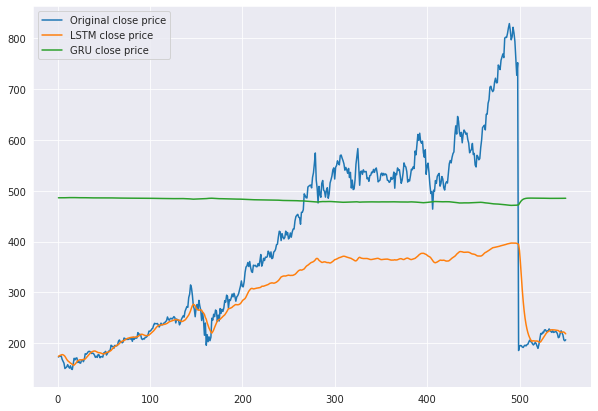

In [31]:
# Visualising the prediction results and compare LSTM and GRU models

#####################

# your code
y_true = close_scaler.inverse_transform(y_test.reshape(-1, 1))
lstm_pred = close_scaler.inverse_transform(lstm_out.cpu().detach().numpy().reshape((-1, 1)))
gru_pred = close_scaler.inverse_transform(gru_out.cpu().detach().numpy().reshape((-1, 1)))
sns.set_style("darkgrid")    
fig = plt.figure()
ax = sns.lineplot(x=list(range(1, len(y_true)+1)), y=y_true.flatten(), label="Original close price")
ax = sns.lineplot(x=list(range(1, len(lstm_pred)+1)), y=lstm_pred.flatten(), label="LSTM close price")
ax = sns.lineplot(x=list(range(1, len(gru_pred)+1)), y=gru_pred.flatten(), label="GRU close price")
fig.set_figheight(7)
fig.set_figwidth(10)
#####################

**Bonus (5%)** \
try denoising techniques and train models again after denoising the prices. Then compare the results with previous step and explain how much improvment you can make by denoising data. 